# Connect 4 CNN Training - Google Colab

This notebook trains Convolutional Neural Networks to play Connect 4.

## Setup Instructions

1. **Upload your data files**:
   - Click the folder icon on the left sidebar
   - Upload `connect4_X_clean.npy` and `connect4_Y_clean.npy`
   - Files will be in `/content/` directory

2. **Enable GPU** (Recommended):
   - Runtime → Change runtime type → Hardware accelerator → GPU
   - This makes training 5-10x faster!

3. **Run all cells** (Runtime → Run all)

4. **Download results**:
   - Trained models (.h5 files)
   - Training plots (.png files)

## Step 1: Check GPU and Setup

In [32]:
# Check if GPU is available
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

print("TensorFlow version:", tf.__version__)
print("\nGPU Status:")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ GPU available: {len(gpus)} GPU(s)")
    for gpu in gpus:
        print(f"  {gpu}")
    print("\n🚀 Training will be FAST!")
else:
    print("⚠️ No GPU detected")
    print("Training will be slower. Consider: Runtime → Change runtime type → GPU")

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

TensorFlow version: 2.19.0

GPU Status:
✓ GPU available: 1 GPU(s)
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

🚀 Training will be FAST!


## Step 2: Load and Prepare Data

Make sure you've uploaded `connect4_X_clean.npy` and `connect4_Y_clean.npy` to the `/content/` folder!

In [33]:
# Update these paths if your files are in a different location
X_PATH = '/content/connect4_X_clean.npy'
Y_PATH = '/content/connect4_Y_clean.npy'

# Check if files exist
if not os.path.exists(X_PATH):
    print(f"❌ ERROR: Cannot find {X_PATH}")
    print("Please upload connect4_X_clean.npy to the /content/ folder")
    print("(Use the folder icon on the left sidebar)")
else:
    print(f"✓ Found X data")

if not os.path.exists(Y_PATH):
    print(f"❌ ERROR: Cannot find {Y_PATH}")
    print("Please upload connect4_Y_clean.npy to the /content/ folder")
else:
    print(f"✓ Found Y data")

✓ Found X data
✓ Found Y data


In [34]:
# Load data
print("Loading data...")

# Load Y first to get number of samples
Y = np.load(Y_PATH)
n_samples = len(Y)
print(f"✓ Loaded Y: {Y.shape}")

# Load X and determine its format
X_raw = np.load(X_PATH)
print(f"✓ Loaded X raw shape: {X_raw.shape}")
print(f"  Total elements: {X_raw.size:,}")

# Determine the format and reshape accordingly
elements_per_sample = X_raw.size // n_samples
print(f"  Elements per sample: {elements_per_sample}")

# Handle different data formats
if elements_per_sample == 84:  # 2-channel format (6x7x2) - YOUR DATA!
    print("  → Format: Already in 2-channel format (6×7×2)")
    print("  ✓ Perfect! Data is already in ideal CNN format")
    X = X_raw  # Already (N, 6, 7, 2)
elif X_raw.shape == (n_samples, 6, 7, 2):  # Check shape directly
    print("  → Format: Already in (N, 6, 7, 2) shape")
    print("  ✓ Perfect! Data is already in ideal CNN format")
    X = X_raw
elif elements_per_sample == 42:  # Flattened 6x7
    print("  → Format: Flattened boards (42 elements each)")
    print("  → Reshaping to (N, 6, 7)")
    X = X_raw.reshape(n_samples, 6, 7)
elif X_raw.shape == (n_samples, 6, 7):  # Already correct shape
    print("  → Format: Already in (N, 6, 7) shape")
    X = X_raw
else:
    print(f"  ⚠️  Unexpected format: {elements_per_sample} elements per sample")
    raise ValueError(f"Cannot handle data with {elements_per_sample} elements per sample")

print(f"\n✓ Data loaded successfully!")
print(f"Final X shape: {X.shape}")
print(f"Y shape: {Y.shape}")
print(f"X dtype: {X.dtype}")

# Show sample data
print(f"\nSample board (first example):")
if len(X.shape) == 4:  # 2-channel format
    print(f"  Channel 0 (player 1): {X[0,:,:,0].sum():.0f} pieces")
    print(f"  Channel 1 (player 2): {X[0,:,:,1].sum():.0f} pieces")
else:  # Standard format
    print(X[0])

print(f"\nY value distribution:")
for i in range(7):
    count = np.sum(Y == i)
    print(f"  Column {i}: {count:,} ({count/len(Y)*100:.1f}%)")

Loading data...
✓ Loaded Y: (215309,)
✓ Loaded X raw shape: (215309, 6, 7, 2)
  Total elements: 18,085,956
  Elements per sample: 84
  → Format: Already in 2-channel format (6×7×2)
  ✓ Perfect! Data is already in ideal CNN format

✓ Data loaded successfully!
Final X shape: (215309, 6, 7, 2)
Y shape: (215309,)
X dtype: float64

Sample board (first example):
  Channel 0 (player 1): 0 pieces
  Channel 1 (player 2): 0 pieces

Y value distribution:
  Column 0: 36,816 (17.1%)
  Column 1: 31,276 (14.5%)
  Column 2: 28,278 (13.1%)
  Column 3: 22,702 (10.5%)
  Column 4: 28,297 (13.1%)
  Column 5: 31,207 (14.5%)
  Column 6: 36,733 (17.1%)


In [35]:
# Data is already in 2-channel format - just ensure float32
X = X.astype(np.float32)
print(f"✓ X converted to {X.dtype} for training efficiency")
print(f"✓ Final shape: {X.shape}")

✓ X converted to float32 for training efficiency
✓ Final shape: (215309, 6, 7, 2)


In [36]:
# Split into train, validation, and test sets
print("Splitting data...")

# First split: separate test set (15%)
X_temp, X_test, Y_temp, Y_test = train_test_split(
    X, Y, test_size=0.15, random_state=42, stratify=Y
)

# Second split: separate train and validation (15% of remaining)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_temp, Y_temp, test_size=0.176, random_state=42, stratify=Y_temp
)

print(f"\n✓ Data split complete:")
print(f"  Training set:   {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  Test set:       {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

Splitting data...

✓ Data split complete:
  Training set:   150,801 samples (70.0%)
  Validation set: 32,211 samples (15.0%)
  Test set:       32,297 samples (15.0%)


## Step 3: Define CNN Architectures

We'll create 3 different architectures to compare.

In [37]:
def create_cnn_v1():
    """Basic CNN - good starting point"""
    model = keras.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                     input_shape=(6, 7, 2), name='conv1'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2'),
        layers.BatchNormalization(),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv4'),
        layers.BatchNormalization(),

        layers.Flatten(),
        layers.Dense(256, activation='relu', name='dense1'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu', name='dense2'),
        layers.Dropout(0.3),
        layers.Dense(7, activation='softmax', name='output')
    ], name='CNN_v1_basic')

    return model

def create_cnn_v2():
    """Deeper CNN with more filters - best performance"""
    model = keras.Sequential([
        layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                     input_shape=(6, 7, 2),
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Conv2D(256, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Conv2D(512, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(512, activation='relu',
                    kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.4),
        layers.Dense(256, activation='relu',
                    kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.4),
        layers.Dense(7, activation='softmax')
    ], name='CNN_v2_deep')

    return model

def create_cnn_v3():
    """CNN with multiple kernel sizes"""
    inputs = layers.Input(shape=(6, 7, 2))

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)

    # Multiple kernel sizes
    conv3x3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    conv3x3 = layers.BatchNormalization()(conv3x3)

    conv2x2 = layers.Conv2D(64, (2, 2), activation='relu', padding='same')(x)
    conv2x2 = layers.BatchNormalization()(conv2x2)

    x = layers.Concatenate()([conv3x3, conv2x2])
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu',
                    kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu',
                    kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(7, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='CNN_v3_multikernel')

    return model

print("✓ Model architectures defined")

✓ Model architectures defined


## Step 4: Training Function

In [38]:
def train_model(model, model_name, epochs=100, batch_size=128):
    """Train a model and save results"""

    print("\n" + "="*70)
    print(f"Training {model_name}")
    print("="*70)

    # Compile
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Print model info
    print(f"\nModel has {model.count_params():,} parameters")

    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            f'{model_name}_best.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]

    # Train
    print("\nStarting training...")
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate on test set
    print("\n" + "="*70)
    print(f"Evaluating {model_name} on test set")
    print("="*70)

    test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Per-column accuracy
    predictions = model.predict(X_test, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)

    print("\nPer-column accuracy:")
    for col in range(7):
        mask = Y_test == col
        if np.sum(mask) > 0:
            accuracy = np.mean(predicted_classes[mask] == Y_test[mask])
            count = np.sum(mask)
            print(f"  Column {col}: {accuracy:.4f} ({count:,} samples)")

    # Plot training history
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].plot(history.history['accuracy'], label='Train', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title(f'{model_name} - Accuracy', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(history.history['loss'], label='Train', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].set_title(f'{model_name} - Loss', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{model_name}_history.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Save final model
    model.save(f'{model_name}_final.h5')
    print(f"\n✓ Saved {model_name}_best.h5 and {model_name}_final.h5")
    print(f"✓ Saved {model_name}_history.png")

    return history, test_accuracy

print("✓ Training function ready")

✓ Training function ready


## Step 5: Train Models

**Choose which models to train:**
- Set `TRAIN_V1 = True` to train the basic model (fastest)
- Set `TRAIN_V2 = True` to train the deep model (best performance)
- Set `TRAIN_V3 = True` to train the multi-kernel model (experimental)

Training all 3 takes about 15-30 minutes on GPU, or 1-2 hours on CPU.


Training CNN_v1_basic

Model has 1,671,431 parameters

Starting training...
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3099 - loss: 1.7368
Epoch 1: val_accuracy improved from -inf to 0.47021, saving model to CNN_v1_basic_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.3099 - loss: 1.7366 - val_accuracy: 0.4702 - val_loss: 1.3349 - learning_rate: 0.0010
Epoch 2/100
1175/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4748 - loss: 1.3560
Epoch 2: val_accuracy improved from 0.47021 to 0.51753, saving model to CNN_v1_basic_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4749 - loss: 1.3558 - val_accuracy: 0.5175 - val_loss: 1.2346 - learning_rate: 0.0010
Epoch 3/100
1168/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5161 - loss: 1.2484
Epoch 3: val_accuracy improved from 0.51753 to 0.55006, saving model to CNN_v1_basic_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5162 - loss: 1.2482 - val_accuracy: 0.5501 - val_loss: 1.1548 - learning_rate: 0.0010
Epoch 4/100
1169/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5520 - loss: 1.1617
Epoch 4: val_accuracy improved from 0.55006 to 0.56648, saving model to CNN_v1_basic_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5521 - loss: 1.1615 - val_accuracy: 0.5665 - val_loss: 1.1078 - learning_rate: 0.0010
Epoch 5/100
1175/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5806 - loss: 1.0789
Epoch 5: val_accuracy improved from 0.56648 to 0.57983, saving model to CNN_v1_basic_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5806 - loss: 1.0788 - val_accuracy: 0.5798 - val_loss: 1.0745 - learning_rate: 0.0010
Epoch 6/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6052 - loss: 1.0061
Epoch 6: val_accuracy improved from 0.57983 to 0.58533, saving model to CNN_v1_basic_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6052 - loss: 1.0061 - val_accuracy: 0.5853 - val_loss: 1.0663 - learning_rate: 0.0010
Epoch 7/100
1173/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6284 - loss: 0.9416
Epoch 7: val_accuracy improved from 0.58533 to 0.58902, saving model to CNN_v1_basic_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6284 - loss: 0.9416 - val_accuracy: 0.5890 - val_loss: 1.0790 - learning_rate: 0.0010
Epoch 8/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6479 - loss: 0.8802
Epoch 8: val_accuracy improved from 0.58902 to 0.59076, saving model to CNN_v1_basic_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6479 - loss: 0.8802 - val_accuracy: 0.5908 - val_loss: 1.1083 - learning_rate: 0.0010
Epoch 9/100
1172/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6740 - loss: 0.8188
Epoch 9: val_accuracy did not improve from 0.59076
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6741 - loss: 0.8187 - val_accuracy: 0.5905 - val_loss: 1.1454 - learning_rate: 0.0010
Epoch 10/100
1169/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6957 - loss: 0.7619
Epoch 10: val_accuracy did not improve from 0.59076
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6958 - loss: 0.7618 - val_accuracy: 0.5894 - val_loss: 1.2408 - learning_rate: 0.0010
Epoch 11/100
1175/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7184 - loss: 0.7050
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: val_accuracy did not improve from 0.59076
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7184 - loss:

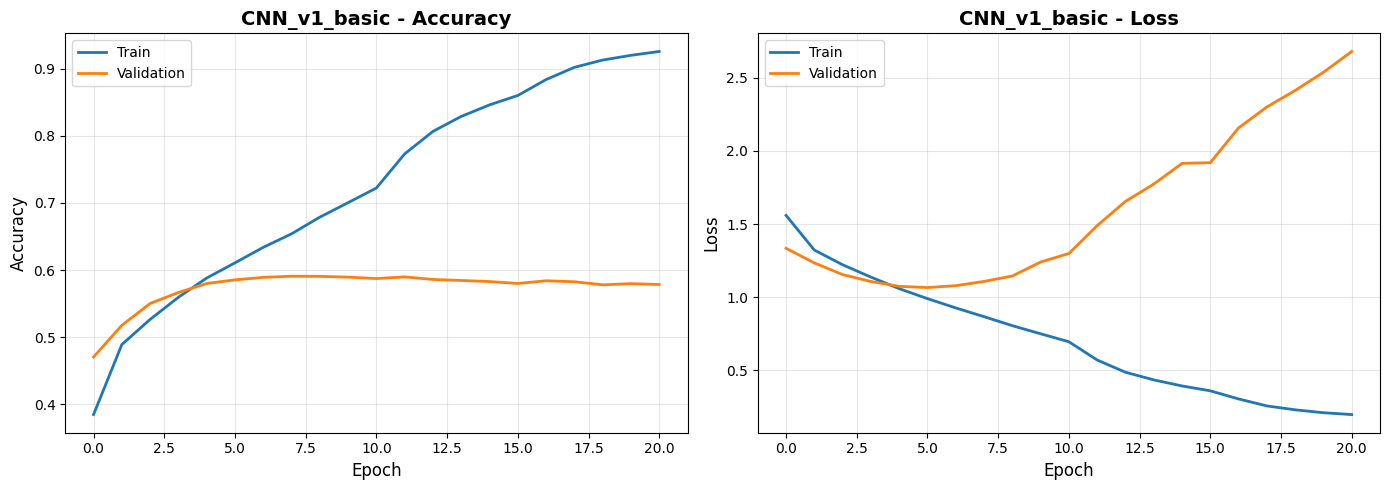


✓ Saved CNN_v1_basic_best.h5 and CNN_v1_basic_final.h5
✓ Saved CNN_v1_basic_history.png

Training CNN_v2_deep

Model has 13,364,231 parameters

Starting training...
Epoch 1/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2034 - loss: 3.7048
Epoch 1: val_accuracy improved from -inf to 0.42448, saving model to CNN_v2_deep_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.2035 - loss: 3.7041 - val_accuracy: 0.4245 - val_loss: 1.9781 - learning_rate: 0.0010
Epoch 2/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4404 - loss: 1.8828
Epoch 2: val_accuracy improved from 0.42448 to 0.50542, saving model to CNN_v2_deep_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4404 - loss: 1.8827 - val_accuracy: 0.5054 - val_loss: 1.6249 - learning_rate: 0.0010
Epoch 3/100
1170/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5122 - loss: 1.6577
Epoch 3: val_accuracy improved from 0.50542 to 0.54469, saving model to CNN_v2_deep_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5123 - loss: 1.6576 - val_accuracy: 0.5447 - val_loss: 1.5420 - learning_rate: 0.0010
Epoch 4/100
1174/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5415 - loss: 1.5950
Epoch 4: val_accuracy improved from 0.54469 to 0.56325, saving model to CNN_v2_deep_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5415 - loss: 1.5948 - val_accuracy: 0.5633 - val_loss: 1.4503 - learning_rate: 0.0010
Epoch 5/100
1173/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5617 - loss: 1.4831
Epoch 5: val_accuracy improved from 0.56325 to 0.57856, saving model to CNN_v2_deep_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5617 - loss: 1.4829 - val_accuracy: 0.5786 - val_loss: 1.3632 - learning_rate: 0.0010
Epoch 6/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5689 - loss: 1.3913
Epoch 6: val_accuracy improved from 0.57856 to 0.59048, saving model to CNN_v2_deep_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5689 - loss: 1.3913 - val_accuracy: 0.5905 - val_loss: 1.2941 - learning_rate: 0.0010
Epoch 7/100
1175/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5751 - loss: 1.3507
Epoch 7: val_accuracy did not improve from 0.59048
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5751 - loss: 1.3506 - val_accuracy: 0.5902 - val_loss: 1.2720 - learning_rate: 0.0010
Epoch 8/100
1168/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5825 - loss: 1.3182
Epoch 8: val_accuracy improved from 0.59048 to 0.59709, saving model to CNN_v2_deep_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5825 - loss: 1.3181 - val_accuracy: 0.5971 - val_loss: 1.2461 - learning_rate: 0.0010
Epoch 9/100
1174/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5836 - loss: 1.2963
Epoch 9: val_accuracy did not improve from 0.59709
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5836 - loss: 1.2963 - val_accuracy: 0.5938 - val_loss: 1.2406 - learning_rate: 0.0010
Epoch 10/100
1176/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5905 - loss: 1.2747
Epoch 10: val_accuracy improved from 0.59709 to 0.60023, saving model to CNN_v2_deep_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5905 - loss: 1.2747 - val_accuracy: 0.6002 - val_loss: 1.2210 - learning_rate: 0.0010
Epoch 11/100
1170/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5908 - loss: 1.2672
Epoch 11: val_accuracy improved from 0.60023 to 0.60513, saving model to CNN_v2_deep_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5908 - loss: 1.2672 - val_accuracy: 0.6051 - val_loss: 1.2116 - learning_rate: 0.0010
Epoch 12/100
1176/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5926 - loss: 1.2571
Epoch 12: val_accuracy improved from 0.60513 to 0.60529, saving model to CNN_v2_deep_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5926 - loss: 1.2571 - val_accuracy: 0.6053 - val_loss: 1.1908 - learning_rate: 0.0010
Epoch 13/100
1170/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5938 - loss: 1.2469
Epoch 13: val_accuracy improved from 0.60529 to 0.60852, saving model to CNN_v2_deep_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5938 - loss: 1.2468 - val_accuracy: 0.6085 - val_loss: 1.1945 - learning_rate: 0.0010
Epoch 14/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5928 - loss: 1.2474
Epoch 14: val_accuracy did not improve from 0.60852
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5928 - loss: 1.2474 - val_accuracy: 0.6062 - val_loss: 1.1887 - learning_rate: 0.0010
Epoch 15/100
1178/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5960 - loss: 1.2377
Epoch 15: val_accuracy did not improve from 0.60852
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5960 - loss: 1.2377 - val_accuracy: 0.6007 - val_loss: 1.2061 - learning_rate: 0.0010
Epoch 16/100
1177/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5962 - loss: 1.2359
Epoch 16: val_accuracy improved from 0.60852 to 0.61057, saving model to CNN_v2_deep_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5962 - loss: 1.2359 - val_accuracy: 0.6106 - val_loss: 1.1876 - learning_rate: 0.0010
Epoch 17/100
1168/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5959 - loss: 1.2303
Epoch 17: val_accuracy improved from 0.61057 to 0.61215, saving model to CNN_v2_deep_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5959 - loss: 1.2303 - val_accuracy: 0.6122 - val_loss: 1.1688 - learning_rate: 0.0010
Epoch 18/100
1175/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5967 - loss: 1.2273
Epoch 18: val_accuracy did not improve from 0.61215
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5967 - loss: 1.2273 - val_accuracy: 0.6086 - val_loss: 1.1687 - learning_rate: 0.0010
Epoch 19/100
1177/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5966 - loss: 1.2230
Epoch 19: val_accuracy improved from 0.61215 to 0.61352, saving model to CNN_v2_deep_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5966 - loss: 1.2230 - val_accuracy: 0.6135 - val_loss: 1.1574 - learning_rate: 0.0010
Epoch 20/100
1171/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5994 - loss: 1.2142
Epoch 20: val_accuracy did not improve from 0.61352
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5994 - loss: 1.2142 - val_accuracy: 0.6056 - val_loss: 1.1758 - learning_rate: 0.0010
Epoch 21/100
1171/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5976 - loss: 1.2228
Epoch 21: val_accuracy improved from 0.61352 to 0.61377, saving model to CNN_v2_deep_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5976 - loss: 1.2228 - val_accuracy: 0.6138 - val_loss: 1.1557 - learning_rate: 0.0010
Epoch 22/100
1175/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5990 - loss: 1.2154
Epoch 22: val_accuracy did not improve from 0.61377
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5990 - loss: 1.2154 - val_accuracy: 0.6129 - val_loss: 1.1513 - learning_rate: 0.0010
Epoch 23/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5982 - loss: 1.2110
Epoch 23: val_accuracy did not improve from 0.61377
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5982 - loss: 1.2110 - val_accuracy: 0.6091 - val_loss: 1.1706 - learning_rate: 0.0010
Epoch 24/100
1177/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6020 - loss: 1.2124
Epoch 24: val_accuracy improved from 0.61377 to 0.61681, saving model to CNN_v2_deep_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6020 - loss: 1.2124 - val_accuracy: 0.6168 - val_loss: 1.1503 - learning_rate: 0.0010
Epoch 25/100
1176/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5999 - loss: 1.2071
Epoch 25: val_accuracy did not improve from 0.61681
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5999 - loss: 1.2071 - val_accuracy: 0.6117 - val_loss: 1.1630 - learning_rate: 0.0010
Epoch 26/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5999 - loss: 1.2095
Epoch 26: val_accuracy did not improve from 0.61681
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5999 - loss: 1.2095 - val_accuracy: 0.6159 - val_loss: 1.1458 - learning_rate: 0.0010
Epoch 27/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6003 - loss: 1.2037
Epoch 27: val_accuracy did not improve from 0.61681
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6003 - loss: 1.2037 - val_accuracy: 0.6158 - val_loss: 1.1510 - learning_rate: 0.0010
Ep

1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6006 - loss: 1.2001 - val_accuracy: 0.6176 - val_loss: 1.1416 - learning_rate: 0.0010
Epoch 32/100
1168/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6025 - loss: 1.1994
Epoch 32: val_accuracy did not improve from 0.61765
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6025 - loss: 1.1994 - val_accuracy: 0.6152 - val_loss: 1.1427 - learning_rate: 0.0010
Epoch 33/100
1172/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6027 - loss: 1.1966
Epoch 33: val_accuracy did not improve from 0.61765
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6027 - loss: 1.1966 - val_accuracy: 0.6163 - val_loss: 1.1405 - learning_rate: 0.0010
Epoch 34/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6025 - loss: 1.1947
Epoch 34: val_accuracy did not improve from 0.61765
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6025 - loss: 1.1947 - val_accuracy: 0.6167 - val_loss: 1.1379 - learning_rate: 0.0010
Ep

1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6032 - loss: 1.1893 - val_accuracy: 0.6192 - val_loss: 1.1458 - learning_rate: 0.0010
Epoch 45/100
1176/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6036 - loss: 1.1885
Epoch 45: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 45: val_accuracy did not improve from 0.61923
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6036 - loss: 1.1885 - val_accuracy: 0.6175 - val_loss: 1.1391 - learning_rate: 0.0010
Epoch 46/100
1177/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6168 - loss: 1.1305
Epoch 46: val_accuracy improved from 0.61923 to 0.62904, saving model to CNN_v2_deep_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6168 - loss: 1.1305 - val_accuracy: 0.6290 - val_loss: 1.0663 - learning_rate: 5.0000e-04
Epoch 47/100
1174/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6222 - loss: 1.0955
Epoch 47: val_accuracy improved from 0.62904 to 0.63044, saving model to CNN_v2_deep_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6222 - loss: 1.0954 - val_accuracy: 0.6304 - val_loss: 1.0559 - learning_rate: 5.0000e-04
Epoch 48/100
1169/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6243 - loss: 1.0851
Epoch 48: val_accuracy improved from 0.63044 to 0.63109, saving model to CNN_v2_deep_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6243 - loss: 1.0851 - val_accuracy: 0.6311 - val_loss: 1.0507 - learning_rate: 5.0000e-04
Epoch 49/100
1176/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6225 - loss: 1.0827
Epoch 49: val_accuracy improved from 0.63109 to 0.63308, saving model to CNN_v2_deep_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6225 - loss: 1.0826 - val_accuracy: 0.6331 - val_loss: 1.0404 - learning_rate: 5.0000e-04
Epoch 50/100
1175/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6248 - loss: 1.0737
Epoch 50: val_accuracy improved from 0.63308 to 0.63357, saving model to CNN_v2_deep_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6248 - loss: 1.0737 - val_accuracy: 0.6336 - val_loss: 1.0451 - learning_rate: 5.0000e-04
Epoch 51/100
1169/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6265 - loss: 1.0740
Epoch 51: val_accuracy did not improve from 0.63357
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6265 - loss: 1.0739 - val_accuracy: 0.6333 - val_loss: 1.0425 - learning_rate: 5.0000e-04
Epoch 52/100
1177/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6267 - loss: 1.0702
Epoch 52: val_accuracy improved from 0.63357 to 0.63391, saving model to CNN_v2_deep_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6267 - loss: 1.0702 - val_accuracy: 0.6339 - val_loss: 1.0414 - learning_rate: 5.0000e-04
Epoch 53/100
1174/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6269 - loss: 1.0695
Epoch 53: val_accuracy did not improve from 0.63391
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6269 - loss: 1.0695 - val_accuracy: 0.6329 - val_loss: 1.0413 - learning_rate: 5.0000e-04
Epoch 54/100
1170/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6270 - loss: 1.0718
Epoch 54: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 54: val_accuracy did not improve from 0.63391
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6270 - loss: 1.0718 - val_accuracy: 0.6305 - val_loss: 1.0446 - learning_rate: 5.0000e-04
Epoch 55/100
1173/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6329 - loss: 1.0379
Epoch 55: val_accuracy improved from 0.63391 to 0.63978, saving model to CNN_v2_deep_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6329 - loss: 1.0378 - val_accuracy: 0.6398 - val_loss: 1.0096 - learning_rate: 2.5000e-04
Epoch 56/100
1172/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6398 - loss: 1.0141
Epoch 56: val_accuracy improved from 0.63978 to 0.64059, saving model to CNN_v2_deep_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6398 - loss: 1.0141 - val_accuracy: 0.6406 - val_loss: 1.0072 - learning_rate: 2.5000e-04
Epoch 57/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6416 - loss: 1.0090
Epoch 57: val_accuracy improved from 0.64059 to 0.64081, saving model to CNN_v2_deep_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6416 - loss: 1.0090 - val_accuracy: 0.6408 - val_loss: 1.0016 - learning_rate: 2.5000e-04
Epoch 58/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6390 - loss: 1.0047
Epoch 58: val_accuracy improved from 0.64081 to 0.64208, saving model to CNN_v2_deep_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6390 - loss: 1.0047 - val_accuracy: 0.6421 - val_loss: 0.9991 - learning_rate: 2.5000e-04
Epoch 59/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6444 - loss: 0.9941
Epoch 59: val_accuracy did not improve from 0.64208
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6444 - loss: 0.9941 - val_accuracy: 0.6409 - val_loss: 1.0020 - learning_rate: 2.5000e-04
Epoch 60/100
1170/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6477 - loss: 0.9926
Epoch 60: val_accuracy did not improve from 0.64208
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6477 - loss: 0.9925 - val_accuracy: 0.6416 - val_loss: 0.9990 - learning_rate: 2.5000e-04
Epoch 61/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6457 - loss: 0.9907
Epoch 61: val_accuracy improved from 0.64208 to 0.64242, saving model to CNN_v2_deep_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6457 - loss: 0.9907 - val_accuracy: 0.6424 - val_loss: 0.9998 - learning_rate: 2.5000e-04
Epoch 62/100
1178/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6448 - loss: 0.9909
Epoch 62: val_accuracy did not improve from 0.64242
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6448 - loss: 0.9909 - val_accuracy: 0.6413 - val_loss: 0.9975 - learning_rate: 2.5000e-04
Epoch 63/100
1174/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6460 - loss: 0.9867
Epoch 63: val_accuracy did not improve from 0.64242
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6460 - loss: 0.9867 - val_accuracy: 0.6384 - val_loss: 1.0043 - learning_rate: 2.5000e-04
Epoch 64/100
1177/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6468 - loss: 0.9853
Epoch 64: val_accuracy did not improve from 0.64242
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6468 - loss: 0.9853 - val_accuracy: 0.6381 - val_loss: 1.0031 - learning_rat

1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6581 - loss: 0.9465 - val_accuracy: 0.6436 - val_loss: 0.9868 - learning_rate: 1.2500e-04
Epoch 70/100
1168/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6616 - loss: 0.9426
Epoch 70: val_accuracy did not improve from 0.64360
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6616 - loss: 0.9426 - val_accuracy: 0.6432 - val_loss: 0.9863 - learning_rate: 1.2500e-04
Epoch 71/100
1177/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6624 - loss: 0.9359
Epoch 71: val_accuracy improved from 0.64360 to 0.64453, saving model to CNN_v2_deep_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6624 - loss: 0.9359 - val_accuracy: 0.6445 - val_loss: 0.9868 - learning_rate: 1.2500e-04
Epoch 72/100
1171/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6621 - loss: 0.9312
Epoch 72: val_accuracy did not improve from 0.64453
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6621 - loss: 0.9312 - val_accuracy: 0.6420 - val_loss: 0.9863 - learning_rate: 1.2500e-04
Epoch 73/100
1174/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6659 - loss: 0.9297
Epoch 73: val_accuracy did not improve from 0.64453
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6659 - loss: 0.9297 - val_accuracy: 0.6425 - val_loss: 0.9877 - learning_rate: 1.2500e-04
Epoch 74/100
1168/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6635 - loss: 0.9270
Epoch 74: val_accuracy did not improve from 0.64453
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6635 - loss: 0.9270 - val_accuracy: 0.6442 - val_loss: 0.9865 - learning_rat

1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6730 - loss: 0.8995 - val_accuracy: 0.6456 - val_loss: 0.9835 - learning_rate: 6.2500e-05
Epoch 80/100
1169/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6746 - loss: 0.8977
Epoch 80: val_accuracy did not improve from 0.64559
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6746 - loss: 0.8977 - val_accuracy: 0.6438 - val_loss: 0.9826 - learning_rate: 6.2500e-05
Epoch 81/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6735 - loss: 0.8938
Epoch 81: val_accuracy did not improve from 0.64559
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6735 - loss: 0.8938 - val_accuracy: 0.6440 - val_loss: 0.9811 - learning_rate: 6.2500e-05
Epoch 82/100
1176/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6750 - loss: 0.8950
Epoch 82: val_accuracy did not improve from 0.64559
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6750 - loss: 0.8950 - val_accuracy: 0.6447 - val_loss: 0.9824 - learning_rat

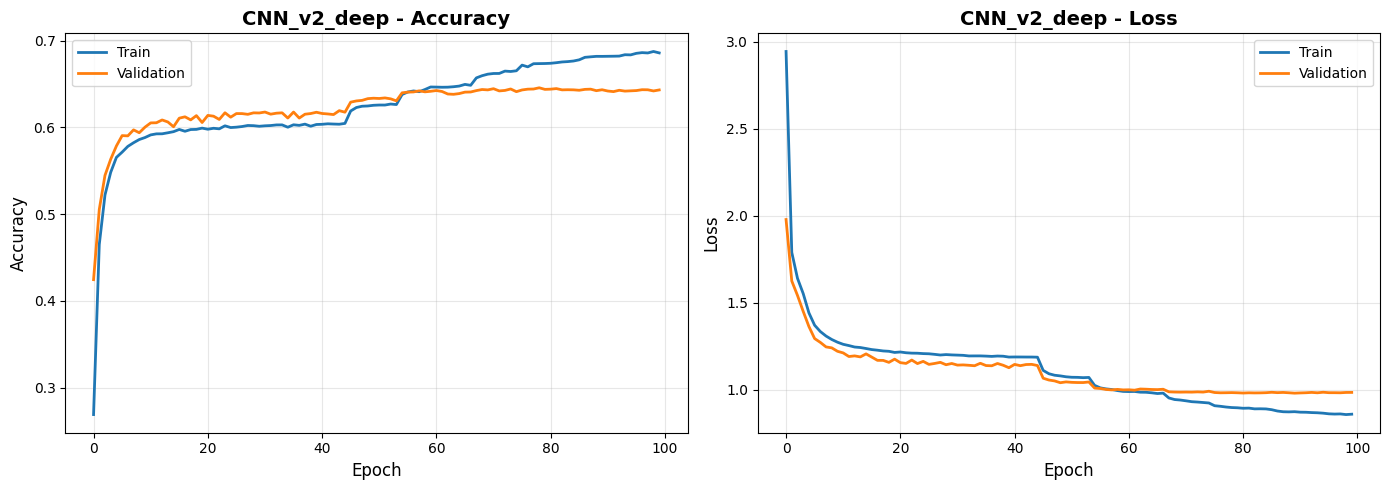


✓ Saved CNN_v2_deep_best.h5 and CNN_v2_deep_final.h5
✓ Saved CNN_v2_deep_history.png

Training CNN_v3_multikernel

Model has 13,268,551 parameters

Starting training...
Epoch 1/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1699 - loss: 3.0194
Epoch 1: val_accuracy improved from -inf to 0.17454, saving model to CNN_v3_multikernel_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - accuracy: 0.1699 - loss: 3.0190 - val_accuracy: 0.1745 - val_loss: 1.9904 - learning_rate: 0.0010
Epoch 2/100
1171/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2148 - loss: 2.0700
Epoch 2: val_accuracy improved from 0.17454 to 0.45407, saving model to CNN_v3_multikernel_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.2154 - loss: 2.0699 - val_accuracy: 0.4541 - val_loss: 1.7797 - learning_rate: 0.0010
Epoch 3/100
1178/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4484 - loss: 1.8192
Epoch 3: val_accuracy improved from 0.45407 to 0.50576, saving model to CNN_v3_multikernel_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.4484 - loss: 1.8191 - val_accuracy: 0.5058 - val_loss: 1.5560 - learning_rate: 0.0010
Epoch 4/100
1178/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5124 - loss: 1.5551
Epoch 4: val_accuracy improved from 0.50576 to 0.56040, saving model to CNN_v3_multikernel_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5124 - loss: 1.5550 - val_accuracy: 0.5604 - val_loss: 1.3435 - learning_rate: 0.0010
Epoch 5/100
1175/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5558 - loss: 1.3860
Epoch 5: val_accuracy improved from 0.56040 to 0.58157, saving model to CNN_v3_multikernel_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5559 - loss: 1.3859 - val_accuracy: 0.5816 - val_loss: 1.2844 - learning_rate: 0.0010
Epoch 6/100
1176/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5834 - loss: 1.2870
Epoch 6: val_accuracy improved from 0.58157 to 0.59675, saving model to CNN_v3_multikernel_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5834 - loss: 1.2869 - val_accuracy: 0.5968 - val_loss: 1.1910 - learning_rate: 0.0010
Epoch 7/100
1176/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5985 - loss: 1.2100
Epoch 7: val_accuracy improved from 0.59675 to 0.60442, saving model to CNN_v3_multikernel_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5985 - loss: 1.2100 - val_accuracy: 0.6044 - val_loss: 1.1663 - learning_rate: 0.0010
Epoch 8/100
1176/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6116 - loss: 1.1647
Epoch 8: val_accuracy improved from 0.60442 to 0.61190, saving model to CNN_v3_multikernel_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6116 - loss: 1.1647 - val_accuracy: 0.6119 - val_loss: 1.1502 - learning_rate: 0.0010
Epoch 9/100
1178/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6207 - loss: 1.1317
Epoch 9: val_accuracy improved from 0.61190 to 0.61364, saving model to CNN_v3_multikernel_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6207 - loss: 1.1317 - val_accuracy: 0.6136 - val_loss: 1.1541 - learning_rate: 0.0010
Epoch 10/100
1177/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6328 - loss: 1.1115
Epoch 10: val_accuracy improved from 0.61364 to 0.61830, saving model to CNN_v3_multikernel_best.h5


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6329 - loss: 1.1115 - val_accuracy: 0.6183 - val_loss: 1.1421 - learning_rate: 0.0010
Epoch 11/100
1178/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6426 - loss: 1.0857
Epoch 11: val_accuracy did not improve from 0.61830
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6426 - loss: 1.0856 - val_accuracy: 0.6156 - val_loss: 1.1459 - learning_rate: 0.0010
Epoch 12/100
1174/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6487 - loss: 1.0706
Epoch 12: val_accuracy did not improve from 0.61830
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6487 - loss: 1.0706 - val_accuracy: 0.6158 - val_loss: 1.1504 - learning_rate: 0.0010
Epoch 13/100
1175/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6561 - loss: 1.0500
Epoch 13: val_accuracy did not improve from 0.61830
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6561 - loss: 1.0500 - val_accuracy: 0.6127 - val_loss: 1.1606 - learning_rate: 0.0010
Ep

1179/1179 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6910 - loss: 0.9259 - val_accuracy: 0.6223 - val_loss: 1.1370 - learning_rate: 5.0000e-04
Epoch 17/100
1175/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7036 - loss: 0.8721
Epoch 17: val_accuracy did not improve from 0.62230
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7036 - loss: 0.8720 - val_accuracy: 0.6208 - val_loss: 1.1389 - learning_rate: 5.0000e-04
Epoch 18/100
1178/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7130 - loss: 0.8508
Epoch 18: val_accuracy did not improve from 0.62230
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7130 - loss: 0.8507 - val_accuracy: 0.6183 - val_loss: 1.1559 - learning_rate: 5.0000e-04
Epoch 19/100
1177/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7211 - loss: 0.8342
Epoch 19: val_accuracy did not improve from 0.62230
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7212 - loss: 0.8341 - val_accuracy: 0.6176 - val_loss: 1.1726 - learning_rat

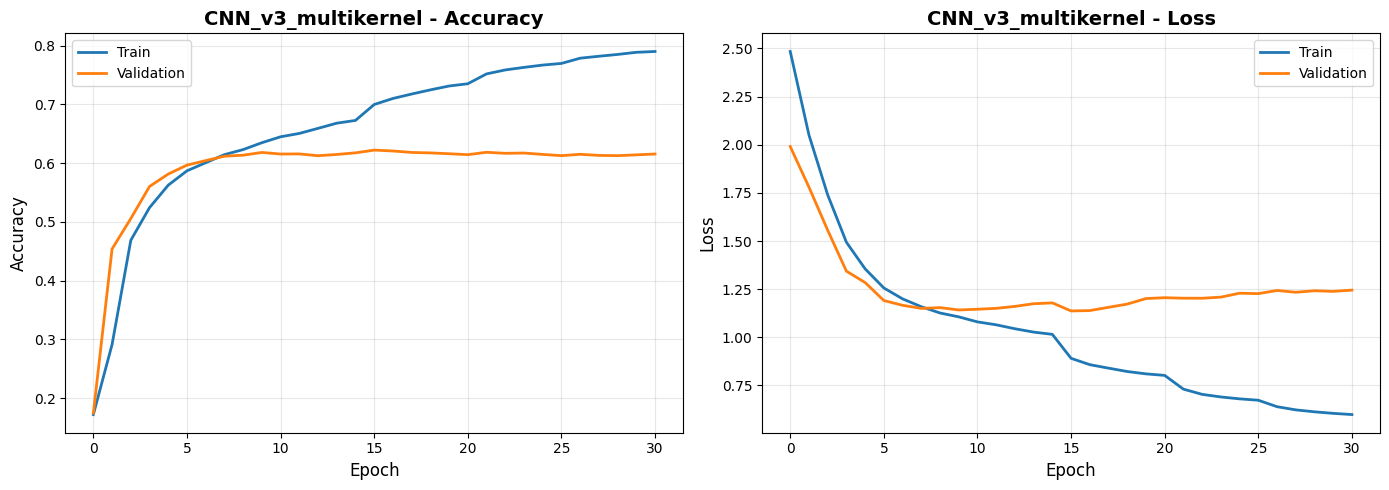


✓ Saved CNN_v3_multikernel_best.h5 and CNN_v3_multikernel_final.h5
✓ Saved CNN_v3_multikernel_history.png

FINAL RESULTS SUMMARY
CNN_v1_basic: 0.5928 (59.28%)
CNN_v2_deep: 0.6478 (64.78%)
CNN_v3_multikernel: 0.6207 (62.07%)

✓ All training complete!


In [39]:
# Configure which models to train
TRAIN_V1 = True   # Basic CNN (recommended)
TRAIN_V2 = True   # Deep CNN (best performance)
TRAIN_V3 = True  # Multi-kernel CNN (optional)

results = {}

# Train CNN v1
if TRAIN_V1:
    model_v1 = create_cnn_v1()
    history_v1, acc_v1 = train_model(model_v1, 'CNN_v1_basic', epochs=100, batch_size=128)
    results['CNN_v1_basic'] = acc_v1

# Train CNN v2
if TRAIN_V2:
    model_v2 = create_cnn_v2()
    history_v2, acc_v2 = train_model(model_v2, 'CNN_v2_deep', epochs=100, batch_size=128)
    results['CNN_v2_deep'] = acc_v2

# Train CNN v3
if TRAIN_V3:
    model_v3 = create_cnn_v3()
    history_v3, acc_v3 = train_model(model_v3, 'CNN_v3_multikernel', epochs=100, batch_size=128)
    results['CNN_v3_multikernel'] = acc_v3

# Print summary
print("\n" + "="*70)
print("FINAL RESULTS SUMMARY")
print("="*70)
for name, acc in results.items():
    print(f"{name}: {acc:.4f} ({acc*100:.2f}%)")
print("\n✓ All training complete!")

## Step 6: Download Your Models

After training, download your files:
1. Click the folder icon on the left
2. Right-click on each file and select "Download"

Files to download:
- `CNN_v1_basic_best.h5` (or v2/v3)
- `CNN_v1_basic_final.h5`
- `CNN_v1_basic_history.png`

In [40]:
# List all saved files
print("Files saved in /content/:")
for file in os.listdir('/content/'):
    if file.endswith('.h5') or file.endswith('.png'):
        size = os.path.getsize(f'/content/{file}') / (1024*1024)  # MB
        print(f"  {file} ({size:.1f} MB)")

Files saved in /content/:
  CNN_v2_deep_history.png (0.1 MB)
  CNN_v2_deep_best.h5 (153.0 MB)
  CNN_v3_multikernel_best.h5 (151.9 MB)
  CNN_v1_basic_final.h5 (19.2 MB)
  CNN_v3_multikernel_final.h5 (151.9 MB)
  CNN_v2_deep_final.h5 (153.0 MB)
  CNN_v3_multikernel_history.png (0.1 MB)
  CNN_v1_basic_history.png (0.1 MB)
  CNN_v1_basic_best.h5 (19.2 MB)


## Step 7: Quick Test of Trained Model

In [47]:
# Load one of your trained models
MODEL_TO_TEST = 'CNN_v2_deep_best.h5'  # Change this to test different models

print(f"Loading {MODEL_TO_TEST}...")
test_model = keras.models.load_model(MODEL_TO_TEST)
print("✓ Model loaded!")

# Test on a few examples
print("\nTesting on 5 random examples:")
for i in range(5):
    idx = np.random.randint(len(X_test))
    board = X_test[idx:idx+1]
    true_move = Y_test[idx]

    prediction = test_model.predict(board, verbose=0)[0]
    predicted_move = np.argmax(prediction)
    confidence = prediction[predicted_move]

    correct = "✓" if predicted_move == true_move else "✗"
    print(f"  Example {i+1}: Predicted={predicted_move}, True={true_move} {correct} (confidence: {confidence:.3f})")

# Test opening move
print("\nTesting opening move (empty board):")
empty_board = np.zeros((1, 6, 7, 2), dtype=np.float32)
opening_pred = test_model.predict(empty_board, verbose=0)[0]
opening_move = np.argmax(opening_pred)
print(f"  Recommended opening: Column {opening_move}")
print(f"  Probabilities: {opening_pred}")

Loading CNN_v2_deep_best.h5...


✓ Model loaded!

Testing on 5 random examples:
  Example 1: Predicted=0, True=0 ✓ (confidence: 0.770)
  Example 2: Predicted=1, True=0 ✗ (confidence: 0.245)
  Example 3: Predicted=1, True=2 ✗ (confidence: 0.460)
  Example 4: Predicted=3, True=3 ✓ (confidence: 0.504)
  Example 5: Predicted=4, True=2 ✗ (confidence: 0.771)

Testing opening move (empty board):
  Recommended opening: Column 3
  Probabilities: [2.2319891e-04 1.4623516e-03 2.6745336e-02 9.3721586e-01 3.2430496e-02
 1.6743024e-03 2.4842049e-04]


## Step 8: Play Against Your Model (Optional)

This creates an interactive game where you can play against your CNN!

In [48]:
# Game logic functions
def update_board(board_temp, color, column):
    board = board_temp.copy()
    colsum = abs(board[0,column])+abs(board[1,column])+abs(board[2,column])+\
             abs(board[3,column])+abs(board[4,column])+abs(board[5,column])
    row = int(5-colsum)
    if row > -0.5:
        board[row,column] = 1 if color == 'plus' else -1
    return board

def find_legal(board):
    return [i for i in range(7) if abs(board[0,i]) < 0.1]

def check_for_win(board, col):
    colsum = abs(board[0,col])+abs(board[1,col])+abs(board[2,col])+\
             abs(board[3,col])+abs(board[4,col])+abs(board[5,col])
    row = int(6-colsum)

    # Check vertical
    if row+3<6:
        vert = board[row,col] + board[row+1,col] + board[row+2,col] + board[row+3,col]
        if abs(vert) == 4:
            return 'plus' if vert == 4 else 'minus'

    # Check horizontal
    for start_col in [col-3, col-2, col-1, col]:
        if 0 <= start_col <= 3:
            hor = board[row,start_col:start_col+4].sum()
            if abs(hor) == 4:
                return 'plus' if hor == 4 else 'minus'

    # Check diagonals (simplified)
    for dr, dc in [(1,1), (1,-1)]:
        for offset in range(-3, 1):
            r, c = row + offset*dr, col + offset*dc
            if 0 <= r <= 2 and 0 <= c <= 6 and c+3*dc >= 0 and c+3*dc < 7:
                try:
                    diag_sum = sum(board[r+i*dr, c+i*dc] for i in range(4))
                    if abs(diag_sum) == 4:
                        return 'plus' if diag_sum == 4 else 'minus'
                except:
                    pass

    return 'nobody'

def display_board(board):
    """Display board in ASCII format with proper alignment"""
    print('\n    0   1   2   3   4   5   6')
    print('  ' + '-'*27)
    for row in range(6):
        line = '  |'
        for col in range(7):
            if board[row,col] == 0:
                line += '   |'
            elif board[row,col] == 1:
                line += ' X |'
            else:
                line += ' O |'
        print(line)
    print('  ' + '-'*27)
    print('    0   1   2   3   4   5   6')

def board_to_input(board, player='plus'):
    if player == 'minus':
        board = -board
    board_input = np.zeros((1, 6, 7, 2), dtype=np.float32)
    board_input[0, :, :, 0] = (board == 1).astype(np.float32)
    board_input[0, :, :, 1] = (board == -1).astype(np.float32)
    return board_input

def get_cnn_move(model, board, color):
    legal = find_legal(board)
    if not legal:
        return None

    board_input = board_to_input(board, color)
    predictions = model.predict(board_input, verbose=0)[0]

    # Mask illegal moves
    masked = np.full(7, -np.inf)
    masked[legal] = predictions[legal]

    return np.argmax(masked)

print("✓ Game functions loaded")
print("\nTo play, run the next cell and enter column numbers (0-6) when prompted")

✓ Game functions loaded

To play, run the next cell and enter column numbers (0-6) when prompted


In [50]:
# Play a game!
print("Starting new game: You (X) vs CNN (O)")
print("Enter column numbers 0-6 to make your move")
print("Enter 'q' to quit\n")

board = np.zeros((6, 7))
winner = 'nobody'
move_count = 0

display_board(board)

while winner == 'nobody':
    move_count += 1

    # Human's turn (player 1 = +1)
    if move_count % 2 == 1:
        legal = find_legal(board)
        if not legal:
            winner = 'tie'
            break

        user_input = input(f"\nYour move (legal: {legal}): ")
        if user_input.lower() == 'q':
            print("Game quit!")
            break

        try:
            move = int(user_input)
            if move not in legal:
                print(f"Illegal move! Choose from {legal}")
                move_count -= 1
                continue
        except:
            print("Invalid input! Enter a number 0-6")
            move_count -= 1
            continue

        board = update_board(board, 'plus', move)
        print(f"\nYou played column {move}")

    # CNN's turn (player 2 = -1)
    else:
        move = get_cnn_move(test_model, board, 'minus')
        if move is None:
            winner = 'tie'
            break

        board = update_board(board, 'minus', move)
        print(f"\nCNN played column {move}")

    display_board(board)
    winner = check_for_win(board, move)

# Show result
print("\n" + "="*40)
if winner == 'plus':
    print("You win! 🎉")
elif winner == 'minus':
    print("CNN wins! 🤖")
elif winner == 'tie':
    print("It's a tie!")
print("="*40)

Starting new game: You (X) vs CNN (O)
Enter column numbers 0-6 to make your move
Enter 'q' to quit


    0   1   2   3   4   5   6
  ---------------------------
  |   |   |   |   |   |   |   |
  |   |   |   |   |   |   |   |
  |   |   |   |   |   |   |   |
  |   |   |   |   |   |   |   |
  |   |   |   |   |   |   |   |
  |   |   |   |   |   |   |   |
  ---------------------------
    0   1   2   3   4   5   6

Your move (legal: [0, 1, 2, 3, 4, 5, 6]): 3

You played column 3

    0   1   2   3   4   5   6
  ---------------------------
  |   |   |   |   |   |   |   |
  |   |   |   |   |   |   |   |
  |   |   |   |   |   |   |   |
  |   |   |   |   |   |   |   |
  |   |   |   |   |   |   |   |
  |   |   |   | X |   |   |   |
  ---------------------------
    0   1   2   3   4   5   6

CNN played column 3

    0   1   2   3   4   5   6
  ---------------------------
  |   |   |   |   |   |   |   |
  |   |   |   |   |   |   |   |
  |   |   |   |   |   |   |   |
  |   |   |   |   |   |   |   

## That's it!

### Next Steps:

1. **Download your models**: Right-click on .h5 and .png files in the file browser
2. **Share with team**: Send the best .h5 model to your deployment teammate
3. **Write-up**: Use the training plots and metrics for your analysis

### Tips:
- CNN_v2_deep usually performs best

# Step 9: Test CNN vs MCTS

In [52]:
"""
Test CNN vs MCTS
Evaluate CNN win rate against MCTS with different skill levels
"""

import numpy as np
import random
from tensorflow import keras

# ============================================================================
# GAME LOGIC (from your notebook)
# ============================================================================

def update_board(board_temp, color, column):
    """Update board with a move"""
    board = board_temp.copy()
    colsum = abs(board[0,column])+abs(board[1,column])+abs(board[2,column])+\
             abs(board[3,column])+abs(board[4,column])+abs(board[5,column])
    row = int(5-colsum)
    if row > -0.5:
        if color == 'plus':
            board[row,column] = 1
        else:
            board[row,column] = -1
    return board

def find_legal(board):
    """Find legal moves"""
    legal = [i for i in range(7) if abs(board[0,i]) < 0.1]
    return legal

def check_for_win(board, col):
    """Check if the last move resulted in a win"""
    nrow = 6
    ncol = 7

    colsum = abs(board[0,col])+abs(board[1,col])+abs(board[2,col])+\
             abs(board[3,col])+abs(board[4,col])+abs(board[5,col])
    row = int(6-colsum)

    # Vertical
    if row+3<6:
        vert = board[row,col] + board[row+1,col] + board[row+2,col] + board[row+3,col]
        if vert == 4:
            return 'v-plus'
        elif vert == -4:
            return 'v-minus'

    # Horizontal (4 positions to check)
    for start_col in [col-3, col-2, col-1, col]:
        if 0 <= start_col <= 3:
            hor = board[row,start_col] + board[row,start_col+1] + \
                  board[row,start_col+2] + board[row,start_col+3]
            if hor == 4:
                return 'h-plus'
            elif hor == -4:
                return 'h-minus'

    # Diagonal down-right
    for offset in range(-3, 1):
        r, c = row + offset, col + offset
        if 0 <= r <= 2 and 0 <= c <= 3:
            DR = board[r,c] + board[r+1,c+1] + board[r+2,c+2] + board[r+3,c+3]
            if DR == 4:
                return 'd-plus'
            elif DR == -4:
                return 'd-minus'

    # Diagonal down-left
    for offset in range(-3, 1):
        r, c = row + offset, col - offset
        if 0 <= r <= 2 and 3 <= c <= 6:
            DL = board[r,c] + board[r+1,c-1] + board[r+2,c-2] + board[r+3,c-3]
            if DL == 4:
                return 'd-plus'
            elif DL == -4:
                return 'd-minus'

    return 'nobody'

def look_for_win(board_, color):
    """Check if there's an immediate winning move"""
    board_ = board_.copy()
    legal = find_legal(board_)
    winner = -1
    for m in legal:
        bt = update_board(board_.copy(), color, m)
        wi = check_for_win(bt, m)
        if wi[2:] == color:
            winner = m
            break
    return winner

def find_all_nonlosers(board, color):
    """Find moves that don't lead to immediate opponent win"""
    if color == 'plus':
        opp = 'minus'
    else:
        opp = 'plus'
    legal = find_legal(board)
    poss_boards = [update_board(board, color, l) for l in legal]
    poss_legal = [find_legal(b) for b in poss_boards]
    allowed = []
    for i in range(len(legal)):
        wins = [j for j in poss_legal[i] if check_for_win(update_board(poss_boards[i], opp, j), j) != 'nobody']
        if len(wins) == 0:
            allowed.append(legal[i])
    return allowed

def rollout(board, next_player):
    """Random rollout for MCTS"""
    winner = 'nobody'
    player = next_player
    while winner == 'nobody':
        legal = find_legal(board)
        if len(legal) == 0:
            winner = 'tie'
            return winner
        move = random.choice(legal)
        board = update_board(board, player, move)
        winner = check_for_win(board, move)

        if player == 'plus':
            player = 'minus'
        else:
            player = 'plus'
    return winner

def back_prop(winner, path, color0, md):
    """Backpropagation for MCTS"""
    for i in range(len(path)):
        board_temp = path[i]

        md[board_temp][0] += 1
        if winner[2] == color0[0]:
            if i % 2 == 1:
                md[board_temp][1] += 1
            else:
                md[board_temp][1] -= 1
        elif winner[2] == 'e':  # tie
            pass
        else:
            if i % 2 == 1:
                md[board_temp][1] -= 1
            else:
                md[board_temp][1] += 1

def mcts(board_temp, color0, nsteps):
    """
    Monte Carlo Tree Search
    nsteps = number of simulations (higher = stronger play)
    """
    board = board_temp.copy()

    # Check for immediate win
    winColumn = look_for_win(board, color0)
    if winColumn > -0.5:
        return winColumn

    # Find non-losing moves
    legal0 = find_all_nonlosers(board, color0)
    if len(legal0) == 0:
        legal0 = find_legal(board)

    # Run MCTS
    mcts_dict = {tuple(board.ravel()): [0, 0]}
    for ijk in range(nsteps):
        color = color0
        winner = 'nobody'
        board_mcts = board.copy()
        path = [tuple(board_mcts.ravel())]

        while winner == 'nobody':
            legal = find_legal(board_mcts)
            if len(legal) == 0:
                winner = 'tie'
                back_prop(winner, path, color0, mcts_dict)
                break

            board_list = []
            for col in legal:
                board_list.append(tuple(update_board(board_mcts, color, col).ravel()))

            for bl in board_list:
                if bl not in mcts_dict.keys():
                    mcts_dict[bl] = [0, 0]

            ucb1 = np.zeros(len(legal))
            for i in range(len(legal)):
                num_denom = mcts_dict[board_list[i]]
                if num_denom[0] == 0:
                    ucb1[i] = 10 * nsteps
                else:
                    ucb1[i] = num_denom[1]/num_denom[0] + 2*np.sqrt(np.log(mcts_dict[path[-1]][0])/mcts_dict[board_list[i]][0])

            chosen = np.argmax(ucb1)
            board_mcts = update_board(board_mcts, color, legal[chosen])
            path.append(tuple(board_mcts.ravel()))
            winner = check_for_win(board_mcts, legal[chosen])

            if winner[2] == color[0]:
                back_prop(winner, path, color0, mcts_dict)
                break

            if color == 'plus':
                color = 'minus'
            else:
                color = 'plus'

            if mcts_dict[tuple(board_mcts.ravel())][0] == 0:
                winner = rollout(board_mcts, color)
                back_prop(winner, path, color0, mcts_dict)
                break

    # Choose best move
    maxval = -np.inf
    best_col = -1
    for col in legal0:
        board_temp = tuple(update_board(board, color0, col).ravel())
        num_denom = mcts_dict[board_temp]
        if num_denom[0] == 0:
            compare = -np.inf
        else:
            compare = num_denom[1] / num_denom[0]
        if compare > maxval:
            maxval = compare
            best_col = col

    return best_col

# ============================================================================
# CNN PLAYER
# ============================================================================

class CNNPlayer:
    """Player that uses trained CNN model"""

    def __init__(self, model_path):
        print(f"Loading CNN model from {model_path}...")
        self.model = keras.models.load_model(model_path)
        print("✓ Model loaded!")

    def board_to_input(self, board, player='plus'):
        """Convert board to CNN input format"""
        if player == 'minus':
            board = -board

        board_input = np.zeros((1, 6, 7, 2), dtype=np.float32)
        board_input[0, :, :, 0] = (board == 1).astype(np.float32)
        board_input[0, :, :, 1] = (board == -1).astype(np.float32)

        return board_input

    def get_move(self, board, color='plus'):
        """Get CNN's recommended move"""
        legal = find_legal(board)
        if len(legal) == 0:
            return None

        board_input = self.board_to_input(board, color)
        predictions = self.model.predict(board_input, verbose=0)[0]

        # Mask illegal moves
        masked_predictions = np.full(7, -np.inf)
        masked_predictions[legal] = predictions[legal]

        return int(np.argmax(masked_predictions))

# ============================================================================
# GAME EVALUATION
# ============================================================================

def play_game(cnn_player, mcts_nsim, cnn_color='plus', verbose=False):
    """
    Play CNN vs MCTS

    Args:
        cnn_player: CNNPlayer instance
        mcts_nsim: Number of MCTS simulations (skill level)
        cnn_color: Which color CNN plays ('plus' or 'minus')
        verbose: Print game progress

    Returns:
        winner: 'cnn', 'mcts', or 'tie'
        num_moves: number of moves in game
    """
    board = np.zeros((6, 7))
    winner = 'nobody'
    move_count = 0

    if cnn_color == 'plus':
        colors = ['plus', 'minus']
    else:
        colors = ['minus', 'plus']

    while winner == 'nobody':
        color = colors[move_count % 2]

        # Determine move
        if (color == 'plus' and cnn_color == 'plus') or \
           (color == 'minus' and cnn_color == 'minus'):
            # CNN's turn
            move = cnn_player.get_move(board, color)
            player_name = "CNN"
        else:
            # MCTS's turn
            move = mcts(board, color, mcts_nsim)
            player_name = f"MCTS({mcts_nsim})"

        if move is None:
            winner = 'tie'
            break

        board = update_board(board, color, move)
        winner = check_for_win(board, move)
        move_count += 1

        if verbose:
            print(f"Move {move_count}: {player_name} ({color}) plays column {move}")

        # Check for tie
        if len(find_legal(board)) == 0 and winner == 'nobody':
            winner = 'tie'

    # Determine winner
    if winner == 'tie':
        return 'tie', move_count
    elif (winner[2:] == 'plus' and cnn_color == 'plus') or \
         (winner[2:] == 'minus' and cnn_color == 'minus'):
        return 'cnn', move_count
    else:
        return 'mcts', move_count

def evaluate_vs_mcts(cnn_player, mcts_nsim, num_games=50, verbose=True):
    """
    Evaluate CNN against MCTS

    Args:
        cnn_player: CNNPlayer instance
        mcts_nsim: MCTS simulation count (500 = strong, 1500 = very strong)
        num_games: Number of games to play
        verbose: Print progress

    Returns:
        Dictionary with results
    """
    results = {'cnn': 0, 'mcts': 0, 'tie': 0}
    move_counts = []

    print(f"\n{'='*60}")
    print(f"CNN vs MCTS({mcts_nsim}) - {num_games} games")
    print(f"{'='*60}\n")

    for i in range(num_games):
        # Alternate who goes first
        cnn_color = 'plus' if i % 2 == 0 else 'minus'

        winner, num_moves = play_game(cnn_player, mcts_nsim, cnn_color, verbose=False)
        results[winner] += 1
        move_counts.append(num_moves)

        if verbose and (i + 1) % 10 == 0:
            print(f"Progress: {i + 1}/{num_games} games...")
            print(f"  Current: CNN {results['cnn']}, MCTS {results['mcts']}, Tie {results['tie']}")

    # Calculate statistics
    cnn_win_rate = results['cnn'] / num_games * 100
    mcts_win_rate = results['mcts'] / num_games * 100
    tie_rate = results['tie'] / num_games * 100
    avg_moves = np.mean(move_counts)

    print(f"\n{'='*60}")
    print("FINAL RESULTS")
    print(f"{'='*60}")
    print(f"Games played: {num_games}")
    print(f"\nWin rates:")
    print(f"  CNN:  {results['cnn']:3d} wins ({cnn_win_rate:5.1f}%)")
    print(f"  MCTS: {results['mcts']:3d} wins ({mcts_win_rate:5.1f}%)")
    print(f"  Tie:  {results['tie']:3d} games ({tie_rate:5.1f}%)")
    print(f"\nAverage game length: {avg_moves:.1f} moves")
    print(f"{'='*60}\n")

    return {
        'results': results,
        'win_rate': cnn_win_rate,
        'avg_moves': avg_moves,
        'mcts_nsim': mcts_nsim
    }

# ============================================================================
# MAIN EVALUATION
# ============================================================================

if __name__ == "__main__":
    # Load your CNN model
    MODEL_PATH = 'CNN_v2_deep_best.h5'  # Update path as needed

    cnn = CNNPlayer(MODEL_PATH)

    # Test against different MCTS strengths
    print("\n" + "="*60)
    print("CNN EVALUATION SUITE")
    print("="*60)

    # Test 1: Weak MCTS (sanity check - should win easily)
    print("\n[Test 1] vs Weak MCTS (100 simulations)")
    weak_results = evaluate_vs_mcts(cnn, mcts_nsim=100, num_games=20)

    # Test 2: Medium MCTS (competitive)
    print("\n[Test 2] vs Medium MCTS (300 simulations)")
    medium_results = evaluate_vs_mcts(cnn, mcts_nsim=300, num_games=30)

    # Test 3: Strong MCTS (your teammate's benchmark)
    print("\n[Test 3] vs Strong MCTS (500 simulations)")
    strong_results = evaluate_vs_mcts(cnn, mcts_nsim=500, num_games=50)

    # Test 4: Very Strong MCTS (challenging)
    print("\n[Test 4] vs Very Strong MCTS (1500 simulations)")
    very_strong_results = evaluate_vs_mcts(cnn, mcts_nsim=1500, num_games=30)

    # Summary
    print("\n" + "="*60)
    print("SUMMARY")
    print("="*60)
    print(f"CNN vs MCTS(100):  {weak_results['win_rate']:.1f}% win rate")
    print(f"CNN vs MCTS(300):  {medium_results['win_rate']:.1f}% win rate")
    print(f"CNN vs MCTS(500):  {strong_results['win_rate']:.1f}% win rate")
    print(f"CNN vs MCTS(1500): {very_strong_results['win_rate']:.1f}% win rate")
    print("="*60)

Loading CNN model from CNN_v2_deep_best.h5...


✓ Model loaded!

CNN EVALUATION SUITE

[Test 1] vs Weak MCTS (100 simulations)

CNN vs MCTS(100) - 20 games

Progress: 10/20 games...
  Current: CNN 7, MCTS 2, Tie 1
Progress: 20/20 games...
  Current: CNN 16, MCTS 3, Tie 1

FINAL RESULTS
Games played: 20

Win rates:
  CNN:   16 wins ( 80.0%)
  MCTS:   3 wins ( 15.0%)
  Tie:    1 games (  5.0%)

Average game length: 26.8 moves


[Test 2] vs Medium MCTS (300 simulations)

CNN vs MCTS(300) - 30 games

Progress: 10/30 games...
  Current: CNN 8, MCTS 1, Tie 1
Progress: 20/30 games...
  Current: CNN 13, MCTS 5, Tie 2
Progress: 30/30 games...
  Current: CNN 23, MCTS 5, Tie 2

FINAL RESULTS
Games played: 30

Win rates:
  CNN:   23 wins ( 76.7%)
  MCTS:   5 wins ( 16.7%)
  Tie:    2 games (  6.7%)

Average game length: 29.2 moves


[Test 3] vs Strong MCTS (500 simulations)

CNN vs MCTS(500) - 50 games

Progress: 10/50 games...
  Current: CNN 6, MCTS 4, Tie 0
Progress: 20/50 games...
  Current: CNN 12, MCTS 8, Tie 0
Progress: 30/50 games...
  C